## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm, boxcox
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



C:\Users\Default User.DESKTOP-GSJ7F4N\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

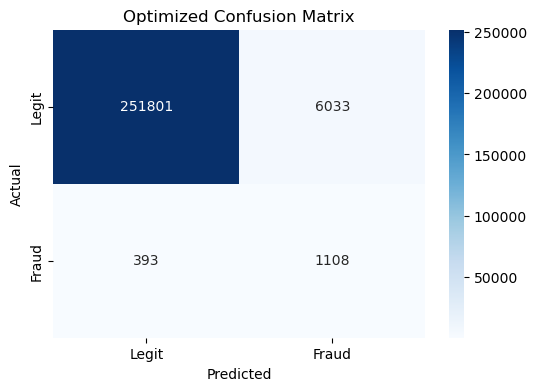

In [2]:

# Load the dataset
file_path = 'fraudTrain.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Gradient Descent to optimize class weights
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    model = LogisticRegression(class_weight=class_weights, max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')

# Train final model with best weight ratio
class_weights = {0: 1, 1: best_weight_ratio}
model = LogisticRegression(class_weight=class_weights, max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy:.4f}')
print('Final Confusion Matrix:\n', conf_matrix)
print('Final Classification Report:\n', class_report)

# Compute final total utility
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]

total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
print(f'Final Total Utility: {total_utility}')

# Visualizing confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized Confusion Matrix')
plt.show()


['amt']
Selected features: ['amt']
['amt', 'dob']
Selected features: ['amt', 'dob']
['amt', 'dob', 'hour']
Selected features: ['amt', 'dob', 'hour']
['amt', 'dob', 'hour', 'month']
Selected features: ['amt', 'dob', 'hour', 'month']
['amt', 'dob', 'hour', 'month', 'gender']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender']
['amt', 'dob', 'hour', 'month', 'gender', 'day']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'uni

['amt', 'dob', 'hour']
Selected features: ['amt', 'dob', 'hour']
['amt', 'dob', 'hour', 'month']
Selected features: ['amt', 'dob', 'hour', 'month']
['amt', 'dob', 'hour', 'month', 'gender']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender']
['amt', 'dob', 'hour', 'month', 'gender', 'day']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'unix_time']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first'

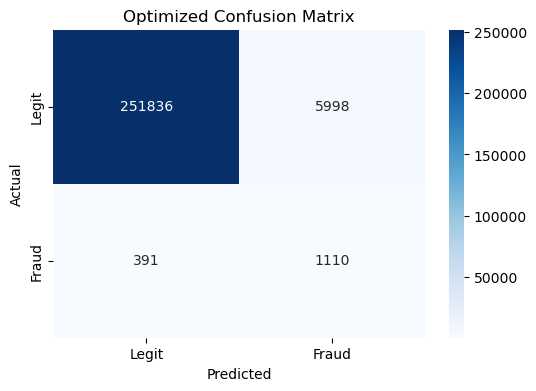

In [6]:
file_path = 'fraudTrain.csv'
df = pd.read_csv(file_path)
# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()
X_train_df[X.columns] = scaler.fit_transform(X_train_df[X.columns])
X_test_df[X.columns] = scaler.transform(X_test_df[X.columns])

# Function for forward stepwise selection using AIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    aic_score = model.aic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, aic_score, z_score

def forward_stepwise_selection(X, y, alpha=0.05, n_jobs=-1):
    selected_features = []
    remaining_features = list(X.columns)
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (aic, z) for feature, aic, z in results}
        best_feature = max(feature_stats, key=lambda f: feature_stats[f][1])
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(selected_features)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features

# Gradient Descent to optimize class weights with stepwise selection
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    
    selected_features = forward_stepwise_selection(X_train_df, y_train)
    X_train_selected = X_train_df[selected_features].values
    X_test_selected = X_test_df[selected_features].values
    
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')

# Train final model with best weight ratio
class_weights = {0: 1, 1: best_weight_ratio}
selected_features = forward_stepwise_selection(X_train_df, y_train)
X_train_selected = X_train_df[selected_features].values
X_test_selected = X_test_df[selected_features].values

model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy:.4f}')
print('Final Confusion Matrix:\n', conf_matrix)
print('Final Classification Report:\n', class_report)

# Compute final total utility
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]

total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
print(f'Final Total Utility: {total_utility}')

# Visualizing confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized Confusion Matrix')
plt.show()

BIC instead

In [7]:
# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()
X_train_df[X.columns] = scaler.fit_transform(X_train_df[X.columns])
X_test_df[X.columns] = scaler.transform(X_test_df[X.columns])

# Function for forward stepwise selection using BIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    bic_score = model.bic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, bic_score, z_score

def forward_stepwise_selection(X, y, alpha=0.05, n_jobs=-1):
    selected_features = []
    remaining_features = list(X.columns)
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (bic, z) for feature, bic, z in results}
        best_feature = min(feature_stats, key=lambda f: feature_stats[f][0])  # Select feature with lowest BIC
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features

# Gradient Descent to optimize class weights with stepwise selection
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    
    selected_features = forward_stepwise_selection(X_train_df, y_train)
    X_train_selected = X_train_df[selected_features].values
    X_test_selected = X_test_df[selected_features].values
    
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')


Selected features: ['amt']
Selected features: ['amt', 'dob']
Selected features: ['amt', 'dob', 'hour']
Selected features: ['amt', 'dob', 'hour', 'month']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year', 'city']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year', 'city', 'category']
Weight Ratio 10: Total Utility = -52905
Selected features: ['amt']
Selected features: ['amt', 'dob']
Selected 

In [3]:

# Load the dataset
file_path = 'fraudTrain.csv'
df = pd.read_csv(file_path)

# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()
X_train_df[X.columns] = scaler.fit_transform(X_train_df[X.columns])
X_test_df[X.columns] = scaler.transform(X_test_df[X.columns])

# Function for forward stepwise selection using BIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    bic_score = model.bic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, bic_score, z_score

def forward_stepwise_selection(X, y, alpha=0.05, n_jobs=-1):
    selected_features = []
    remaining_features = list(X.columns)
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (bic, z) for feature, bic, z in results}
        best_feature = min(feature_stats, key=lambda f: feature_stats[f][0])  # Select feature with lowest BIC
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features


# Train final model with best weight ratio which is 100 for forward untransformed no pca bic
class_weights2 = {0: 1, 1: 100}
selected_features2 = forward_stepwise_selection(X_train_df, y_train)
X_train_selected2 = X_train_df[selected_features2].values
X_test_selected2 = X_test_df[selected_features2].values

model2 = LogisticRegression(class_weight=class_weights2, max_iter=500, solver='lbfgs', n_jobs=-1)
model2.fit(X_train_selected2, y_train)
y_pred2 = model2.predict(X_test_selected2)

# Evaluate model performance
accuracy2 = accuracy_score(y_test, y_pred)
conf_matrix2 = confusion_matrix(y_test, y_pred)
class_report2 = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy2:.4f}')
print('Final Confusion Matrix:\n', conf_matrix2)
print('Final Classification Report:\n', class_report2)

# Compute final total utility
TP2 = conf_matrix2[1, 1]
FN2 = conf_matrix2[1, 0]
FP2 = conf_matrix2[0, 1]

total_utility2 = (TP2 * (S_L)) - (FN2 * C) - (FP2 * P)
print(f'Final Total Utility: {total_utility}')

# Visualizing confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized Confusion Matrix')
plt.show()

Selected features: ['amt']
Selected features: ['amt', 'dob']
Selected features: ['amt', 'dob', 'hour']
Selected features: ['amt', 'dob', 'hour', 'month']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year', 'city']
Selected features: ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year', 'city', 'category']


NameError: name 'model' is not defined

code that uses the best model for validation set

Final Model Accuracy: 0.9754
Final Confusion Matrix:
 [[251838   5996]
 [   391   1110]]
Final Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    257834
         1.0       0.16      0.74      0.26      1501

    accuracy                           0.98    259335
   macro avg       0.58      0.86      0.62    259335
weighted avg       0.99      0.98      0.98    259335

Final Total Utility: -13580


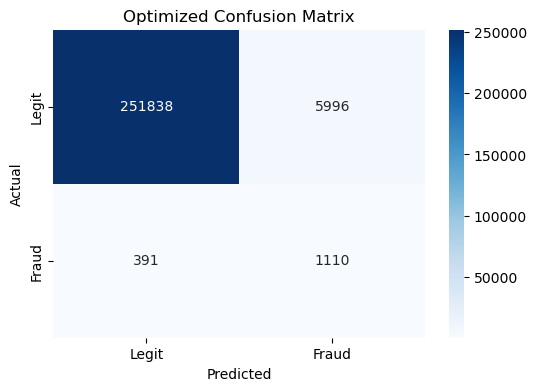

In [4]:
# Define selected features manually
selected_features2 = ['amt', 'dob', 'hour', 'month', 'gender', 'day', 'first', 'state', 'city_pop', 'year', 'city', 'category']

# Recreate training and testing matrices using selected features
X_train_selected2 = X_train_df[selected_features2].values
X_test_selected2 = X_test_df[selected_features2].values

# Set class weights and train logistic regression model
class_weights2 = {0: 1, 1: 100}
model2 = LogisticRegression(class_weight=class_weights2, max_iter=500, solver='lbfgs', n_jobs=-1)
model2.fit(X_train_selected2, y_train)
y_pred2 = model2.predict(X_test_selected2)

# Evaluate model performance
accuracy2 = accuracy_score(y_test, y_pred2)
conf_matrix2 = confusion_matrix(y_test, y_pred2)
class_report2 = classification_report(y_test, y_pred2)

print(f'Final Model Accuracy: {accuracy2:.4f}')
print('Final Confusion Matrix:\n', conf_matrix2)
print('Final Classification Report:\n', class_report2)

# Compute final total utility
S_L = 50
C = 100
P = 5
TP2 = conf_matrix2[1, 1]
FN2 = conf_matrix2[1, 0]
FP2 = conf_matrix2[0, 1]

total_utility2 = (TP2 * S_L) - (FN2 * C) - (FP2 * P)
print(f'Final Total Utility: {total_utility2}')

# Visualizing confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized Confusion Matrix')
plt.show()


## Code that picks the five best variables from an initial model, then uses forward AIC from there

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
file_path = '/mnt/data/fraudTrain.csv'
df = pd.read_csv(file_path)

# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()
X_train_df[X.columns] = scaler.fit_transform(X_train_df[X.columns])
X_test_df[X.columns] = scaler.transform(X_test_df[X.columns])

# Function for forward stepwise selection using AIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    aic_score = model.aic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, aic_score, z_score

def forward_stepwise_selection(X, y, initial_features, alpha=0.05, n_jobs=-1):
    selected_features = initial_features.copy()
    remaining_features = [f for f in X.columns if f not in selected_features]
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (aic, z) for feature, aic, z in results}
        best_feature = max(feature_stats, key=lambda f: feature_stats[f][1])
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features

# Gradient Descent to optimize class weights with stepwise selection
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    
    # Fit an initial model with all features
    X_temp = sm.add_constant(X_train_df)
    model = sm.Logit(y_train, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    
    # Select top 5 features based on z-score from the initial model
    top_features = model.pvalues.abs().sort_values().index[1:6].tolist()
    
    # Perform forward stepwise selection starting with these top features
    selected_features = forward_stepwise_selection(X_train_df, y_train, top_features)
    X_train_selected = X_train_df[selected_features].values
    X_test_selected = X_test_df[selected_features].values
    
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')


transforming variables, no pca, bic forward


In [10]:

# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Transform numeric features to satisfy logistic regression assumptions
numeric_cols = X_train_df.select_dtypes(include=[np.number]).columns
pt = PowerTransformer(method='yeo-johnson')
X_train_df[numeric_cols] = pt.fit_transform(X_train_df[numeric_cols])
X_test_df[numeric_cols] = pt.transform(X_test_df[numeric_cols])

# Standardize numerical features
scaler = StandardScaler()
X_train_df[numeric_cols] = scaler.fit_transform(X_train_df[numeric_cols])
X_test_df[numeric_cols] = scaler.transform(X_test_df[numeric_cols])

# Function for forward stepwise selection using BIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    bic_score = model.bic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, bic_score, z_score

def forward_stepwise_selection(X, y, alpha=0.05, n_jobs=-1):
    selected_features = []
    remaining_features = list(X.columns)
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (bic, z) for feature, bic, z in results}
        best_feature = min(feature_stats, key=lambda f: feature_stats[f][0])  # Select feature with lowest BIC
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features

# Gradient Descent to optimize class weights with stepwise selection
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    
    selected_features = forward_stepwise_selection(X_train_df, y_train)
    X_train_selected = X_train_df[selected_features].values
    X_test_selected = X_test_df[selected_features].values
    
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')


C:\Users\Default User.DESKTOP-GSJ7F4N\anaconda3\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Selected features: ['amt']
Selected features: ['amt', 'dob']
Selected features: ['amt', 'dob', 'hour']
Selected features: ['amt', 'dob', 'hour', 'month']
Selected features: ['amt', 'dob', 'hour', 'month', 'category']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'state']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'state', 'first']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'state', 'first', 'year']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'state', 'first', 'year', 'unix_time']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'state', 'first', 'year', 'unix_time', 'Unnamed: 0']
Selected features: ['amt', 'dob', 'hour', 'month', 'category', 'gender', 'day', 'stat

applying pca post standardization and before yeo-johnson transformation, bic forward

# TODO: edit the code so that it prints what the PCA variables are made up of at the end.

In [16]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
file_path = 'fraudTrain.csv'
df = pd.read_csv(file_path)

# Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Fill missing values in categorical columns with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert timestamp column into datetime and extract useful features
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['year'] = df['trans_date_trans_time'].dt.year
    df = df.drop(columns=['trans_date_trans_time'])

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame to preserve column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
numeric_cols = X_train_df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_df[numeric_cols] = scaler.fit_transform(X_train_df[numeric_cols])
X_test_df[numeric_cols] = scaler.transform(X_test_df[numeric_cols])

# Apply PCA transformation to keep the same number of components as original features
pca = PCA(n_components=len(numeric_cols))
X_train_pca = pca.fit_transform(X_train_df[numeric_cols])
X_test_pca = pca.transform(X_test_df[numeric_cols])

# Convert PCA results to DataFrame
pca_columns = [f'PC{i+1}' for i in range(len(numeric_cols))]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train_df.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test_df.index)

# Transform PCA components to satisfy logistic regression assumptions
pt = PowerTransformer(method='yeo-johnson')
X_train_pca_df[pca_columns] = pt.fit_transform(X_train_pca_df[pca_columns])
X_test_pca_df[pca_columns] = pt.transform(X_test_pca_df[pca_columns])

# Function for forward stepwise selection using BIC and z-score with parallel processing
def compute_feature_stats(feature, selected_features, X, y):
    temp_features = selected_features + [feature]
    X_temp = sm.add_constant(X[temp_features])
    model = sm.Logit(y, X_temp).fit(disp=0, maxiter=500, method='lbfgs')
    bic_score = model.bic
    z_score = abs(model.params[feature] / model.bse[feature])
    return feature, bic_score, z_score

def forward_stepwise_selection(X, y, alpha=0.05, n_jobs=-1):
    selected_features = []
    remaining_features = list(X.columns)
    z_threshold = norm.ppf(1 - alpha / 2)
    
    while remaining_features:
        results = Parallel(n_jobs=n_jobs)(delayed(compute_feature_stats)(feature, selected_features, X, y) for feature in remaining_features)
        
        feature_stats = {feature: (bic, z) for feature, bic, z in results}
        best_feature = min(feature_stats, key=lambda f: feature_stats[f][0])  # Select feature with lowest BIC
        
        if feature_stats[best_feature][1] >= z_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
        
        print(f'Selected features: {selected_features}')
    
    return selected_features

# Gradient Descent to optimize class weights with stepwise selection
best_utility = float('-inf')
best_weight_ratio = 1

for weight_ratio in [10, 50, 100, 500, 1000, 5000]:
    class_weights = {0: 1, 1: weight_ratio}
    
    selected_features = forward_stepwise_selection(X_train_pca_df, y_train)
    X_train_selected = X_train_pca_df[selected_features].values
    X_test_selected = X_test_pca_df[selected_features].values
    
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute total utility
    S_L = 50  # Savings from preventing fraud minus investigation cost
    C = 100  # Cost of undetected fraud
    P = 5  # Penalty for false positives
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    
    total_utility = (TP * (S_L)) - (FN * C) - (FP * P)
    print(f'Weight Ratio {weight_ratio}: Total Utility = {total_utility}')
    
    if total_utility > best_utility:
        best_utility = total_utility
        best_weight_ratio = weight_ratio

print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')


Selected features: ['PC11']
Selected features: ['PC11', 'PC10']
Selected features: ['PC11', 'PC10', 'PC20']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23', 'PC17']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23', 'PC17', 'PC14']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23', 'PC17', 'PC14', 'PC6']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23', 'PC17', 'PC14', 'PC6', 'PC7']
Selected features: ['PC11', 'PC10', 'PC20', 'PC5', 'PC9', 'PC12', 'PC18', 'PC23', 'PC17', 'PC14', 'PC6', 'PC7', 'PC16']
Selected features: ['PC11', 'PC10', 

KeyboardInterrupt: 

In [6]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the training dataset
train_path = 'fraudTrain.csv'
df = pd.read_csv(train_path)

# Preprocessing function to prepare data consistently
def preprocess(df):
    imputer = SimpleImputer(strategy='median')
    df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    if 'trans_date_trans_time' in df.columns:
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day'] = df['trans_date_trans_time'].dt.day
        df['month'] = df['trans_date_trans_time'].dt.month
        df['year'] = df['trans_date_trans_time'].dt.year
        df = df.drop(columns=['trans_date_trans_time'])
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

df = preprocess(df)

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

numeric_cols = X_train_df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_df[numeric_cols] = scaler.fit_transform(X_train_df[numeric_cols])
X_val_df[numeric_cols] = scaler.transform(X_val_df[numeric_cols])

# Apply PCA to preserve 95% variance
pca = PCA(n_components=1.00)
X_train_pca = pca.fit_transform(X_train_df[numeric_cols])
X_val_pca = pca.transform(X_val_df[numeric_cols])

pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train_df.index)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns, index=X_val_df.index)

pt = PowerTransformer(method='yeo-johnson')
X_train_pca_df[pca_columns] = pt.fit_transform(X_train_pca_df[pca_columns])
X_val_pca_df[pca_columns] = pt.transform(X_val_pca_df[pca_columns])

S_L, C, P = 50, 100, 5

def evaluate_model(weight_ratio):
    class_weights = {0: 1, 1: weight_ratio}
    model = LogisticRegression(class_weight=class_weights, max_iter=500, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_pca_df, y_train)
    y_pred = model.predict(X_val_pca_df)
    conf_matrix = confusion_matrix(y_val, y_pred)
    TP, FN, FP = conf_matrix[1, 1], conf_matrix[1, 0], conf_matrix[0, 1]
    total_utility = (TP * S_L) - (FN * C) - (FP * P)
    return total_utility, model, conf_matrix

def bisection_search(low, high):
    best_utility = float('-inf')
    best_weight = None
    best_model = None
    best_matrix = None

    while low <= high:
        mid = (low + high) // 2
        mid_utility, model, matrix = evaluate_model(mid)
        print(f"Trying weight {mid}, utility: {mid_utility}")

        if mid_utility > best_utility:
            best_utility = mid_utility
            best_weight = mid
            best_model = model
            best_matrix = matrix

        if low == high:
            break

        left_utility = evaluate_model(mid - 1)[0] if mid > low else float('-inf')
        right_utility = evaluate_model(mid + 1)[0] if mid < high else float('-inf')

        if left_utility > mid_utility:
            high = mid - 1
        elif right_utility > mid_utility:
            low = mid + 1
        else:
            break

    return best_weight, best_utility, best_model, best_matrix

best_weight_ratio, best_utility, best_model, conf_matrix = bisection_search(50, 500)
print(f'Best weight ratio: {best_weight_ratio} with utility {best_utility}')
print('Best Confusion Matrix (Validation Set):')
print(conf_matrix)

# PCA components
components_df = pd.DataFrame(pca.components_, columns=numeric_cols)
print("\nPCA Component Loadings:")
print(components_df)

# Now evaluate on test set
test_df = pd.read_csv('fraudTest.csv')
test_df = preprocess(test_df)
X_test_final = test_df.drop(columns=['is_fraud'])
y_test_final = test_df['is_fraud']
X_test_final[numeric_cols] = scaler.transform(X_test_final[numeric_cols])
X_test_pca = pca.transform(X_test_final[numeric_cols])
X_test_pca = pt.transform(X_test_pca)
X_test_final_df = pd.DataFrame(X_test_pca, columns=pca_columns)

y_pred_test = best_model.predict(X_test_final_df)
conf_matrix_test = confusion_matrix(y_test_final, y_pred_test)
TP, FN, FP = conf_matrix_test[1, 1], conf_matrix_test[1, 0], conf_matrix_test[0, 1]
test_utility = (TP * S_L) - (FN * C) - (FP * P)

print('\nFinal Test Set Confusion Matrix:')
print(conf_matrix_test)
print(f'Test Set Total Utility: {test_utility}')


InvalidParameterError: The 'n_components' parameter of PCA must be an int in the range [0, inf), a float in the range (0.0, 1.0), a str among {'mle'} or None. Got 1.0 instead.